In [1]:
import math
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import ndimage, misc

In [2]:
# Change presentation settings
%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (15.0, 8.0)
matplotlib.rcParams["xtick.labelsize"] = 16
matplotlib.rcParams["ytick.labelsize"] = 16
matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.titlesize"] = 16
matplotlib.rcParams["figure.titlesize"] = 16
matplotlib.rcParams["axes.labelsize"] = 14
matplotlib.rcParams["legend.fontsize"] = 14

In [3]:
lumi_directory = data_directory = "./lumi"

In [4]:
int_lumi = pd.read_csv(("%s/int_lumi.csv" % lumi_directory),
           names=["run:fill", "ls", "time", "beamstatus", "energy", "delivered", "recorded", "avgpu", "source"])

int_lumi2 = pd.read_csv(("%s/lumi_per_ls.csv" % lumi_directory),
           names=["run:fill", "ls", "time", "beamstatus", "energy", "delivered", "recorded", "avgpu", "source"])

In [5]:
int_lumi['run'], int_lumi['fill'] = int_lumi['run:fill'].str.split(':', 1).str
int_lumi2['run'], int_lumi2['fill'] = int_lumi2['run:fill'].str.split(':', 1).str
int_lumi['ls_start'], int_lumi['ls_end'] = int_lumi['ls'].str.split(':', 1).str
int_lumi2['ls_start'], int_lumi2['ls_end'] = int_lumi2['ls'].str.split(':', 1).str
#print int_lumi2

In [6]:
#int_lumi["delivered"].dtype

In [7]:
int_lumi.drop(int_lumi.index[[0,1,2034,2035,2036]], inplace=True)
int_lumi2.drop(int_lumi2.index[[0,1,2034,2035,2036]], inplace=True)
#print int_lumi

In [8]:
print int_lumi2

         run:fill         ls               time    beamstatus energy  \
2     306777:6396        1:1  11/17/17 21:48:20  STABLE BEAMS   2510   
3     306777:6396        2:2  11/17/17 21:48:43  STABLE BEAMS   2510   
4     306777:6396        3:3  11/17/17 21:49:06  STABLE BEAMS   2510   
5     306777:6396        4:4  11/17/17 21:49:30  STABLE BEAMS   2510   
6     306777:6396        5:5  11/17/17 21:49:53  STABLE BEAMS   2510   
7     306777:6396        6:6  11/17/17 21:50:16  STABLE BEAMS   2510   
8     306777:6396        7:7  11/17/17 21:50:40  STABLE BEAMS   2510   
9     306777:6396        8:8  11/17/17 21:51:03  STABLE BEAMS   2510   
10    306777:6396        9:9  11/17/17 21:51:26  STABLE BEAMS   2510   
11    306777:6396      10:10  11/17/17 21:51:49  STABLE BEAMS   2510   
12    306777:6396      11:11  11/17/17 21:52:13  STABLE BEAMS   2510   
13    306777:6396      12:12  11/17/17 21:52:36  STABLE BEAMS   2510   
14    306777:6396      13:13  11/17/17 21:52:59  STABLE BEAMS   

In [9]:
int_lumi["delivered"] = int_lumi["delivered"].astype('float64')
int_lumi["recorded"] = int_lumi["recorded"].astype('float64')
int_lumi2["delivered"] = int_lumi2["delivered"].astype('float64')
int_lumi2["recorded"] = int_lumi2["recorded"].astype('float64') 

In [10]:
int_lumi["delivered"].dtype
int_lumi["inst_lumi_del"] = int_lumi["delivered"]/23;
int_lumi["inst_lumi_rec"] = int_lumi["recorded"]/23;

In [11]:
def transform_time(data):
    from datetime import datetime
    time_str = data.time
    #print time_str
    datetime_object = datetime.strptime(time_str, "%m/%d/%y %H:%M:%S")
    #print datetime_object
    return datetime_object

In [12]:
int_lumi["time"] = int_lumi.apply(transform_time, axis=1);
int_lumi2["time"] = int_lumi2.apply(transform_time, axis=1);

In [13]:
#print int_lumi["time"]

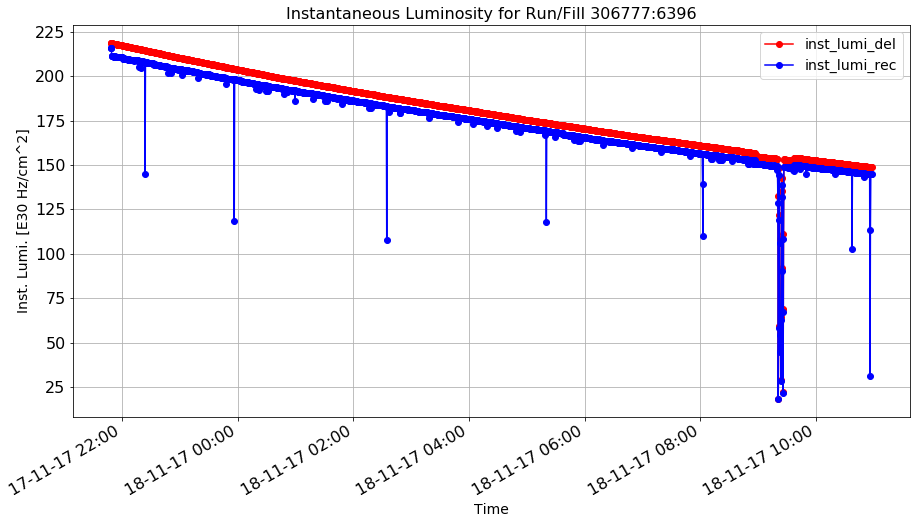

In [14]:
def plot_inst_lumi(x_val, y_val, z_val, title):
    import datetime
    import matplotlib.dates as mdates
    fig, ax = plt.subplots()
    plt.xlabel("Time")
    plt.ylabel("Inst. Lumi. [E30 Hz/cm^2]")
    xfmt = mdates.DateFormatter('%d-%m-%y %H:%M')
    ax.xaxis.set_major_formatter(xfmt)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(x_val, y_val, 'ro-')
    plt.plot(x_val, z_val, 'bo-')
    plt.title(title)
    plt.legend(loc="best")
    plt.show();
    
plot_inst_lumi(int_lumi["time"], int_lumi["inst_lumi_del"], int_lumi["inst_lumi_rec"], "Instantaneous Luminosity for Run/Fill "+int_lumi["run:fill"][2])

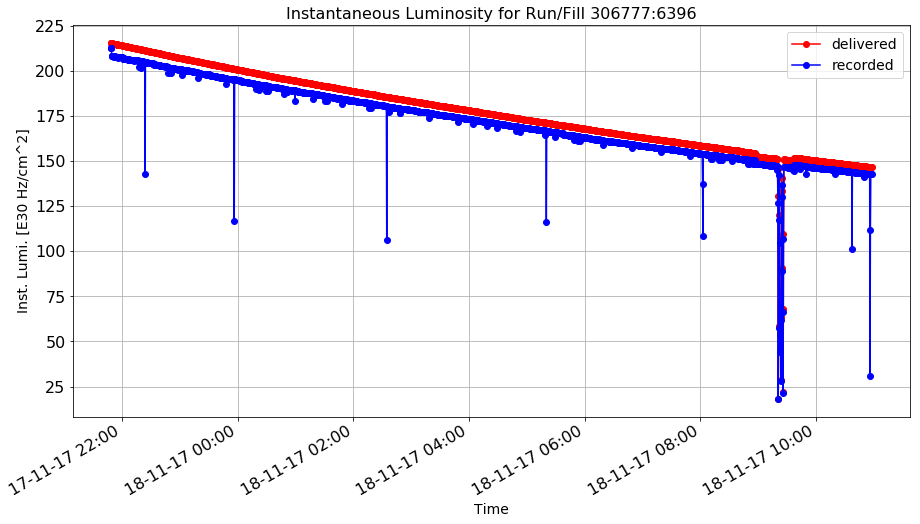

In [15]:
plot_inst_lumi(int_lumi2["time"], int_lumi2["delivered"], int_lumi2["recorded"], "Instantaneous Luminosity for Run/Fill "+int_lumi["run:fill"][2])

In [16]:
int_lumi3 = pd.read_csv(("%s/lumi_per_bx.csv" % lumi_directory),
           names=["run:fill", "ls", "time", "beamstatus", "energy", "delivered", "recorded", "avgpu", "source", "bx"])

In [17]:
int_lumi3.drop(int_lumi3.index[[0,1,2034,2035,2036]], inplace=True)
int_lumi3['run'], int_lumi2['fill'] = int_lumi3['run:fill'].str.split(':', 1).str
int_lumi3['ls_start'], int_lumi2['ls_end'] = int_lumi3['ls'].str.split(':', 1).str

In [18]:
#print int_lumi3["bx"]

In [19]:
def convertToArray(data):
    temp = data.split()
    temp2 = map(lambda each:each.strip("["),temp)
    temp3 = map(lambda each:each.strip("]"),temp2)
    return temp3
int_lumi3["bx"] = int_lumi3["bx"].apply(convertToArray)

In [20]:
#print int_lumi3["bx"].iloc[0]
print len(int_lumi3["bx"].iloc[0])

10692


In [21]:
def slice_it(data, size):
    temp = zip(*[iter(data)]*size)
    return temp

def splitArray(data):
    temp = map(float, data)
    temp2 = slice_it(temp, 3)
    return temp2

In [22]:
int_lumi3["bx"] = int_lumi3["bx"].apply(splitArray)

In [23]:
#print int_lumi3["bx"].iloc[0]

In [24]:
newdf = pd.DataFrame()
def transform(olddf):
    list = olddf.iloc[0]
    tempDF = pd.DataFrame(list, columns = ['BX', 'lumiDel', 'lumiRec'])
    for i in range(1, len(olddf)):
        list = olddf.iloc[i]
        tempDF = tempDF.append(pd.DataFrame(list, columns = ['BX', 'lumiDel', 'lumiRec']))
    return tempDF

In [25]:
newdf = transform(int_lumi3["bx"])

In [26]:
#print newdf

In [27]:
rates_directory = "./rates"
df_rates = pd.read_csv(("%s/dt_rates.csv" % rates_directory),
           names=["run", "time", "board", "RPC1", "RPC2", "RPC3", "RPC4", "DT1", "DT2", "DT3", "DT4", "DT5"])

In [28]:
print df_rates

         run                        time     board    RPC1    RPC2    RPC3  \
0     306777  2017-11-17 21:47:37.525678    YB0_S1       3   60293       1   
1     306777  2017-11-17 21:47:37.525678    YB0_S2   61790      14       5   
2     306777  2017-11-17 21:47:37.525678    YB0_S3  128526       2       0   
3     306777  2017-11-17 21:47:37.525678    YB0_S4     174     320   41726   
4     306777  2017-11-17 21:47:37.525678    YB0_S5   22756    4046    2016   
5     306777  2017-11-17 21:47:37.525678    YB0_S6    3387   10906    1913   
6     306777  2017-11-17 21:47:37.525678    YB0_S7    1413    5551    3203   
7     306777  2017-11-17 21:47:37.525678    YB0_S8    1482    7009   22798   
8     306777  2017-11-17 21:47:37.525678    YB0_S9    2605    3888    2582   
9     306777  2017-11-17 21:47:37.525678   YB0_S10    2250    3066    3004   
10    306777  2017-11-17 21:47:37.525678   YB0_S11    9735    4980    1871   
11    306777  2017-11-17 21:47:37.525678   YB0_S12    4341   108

In [29]:
df_rates['wheel'], df_rates['sector'] = df_rates['board'].str.split('_', 1).str

In [30]:
print df_rates

         run                        time     board    RPC1    RPC2    RPC3  \
0     306777  2017-11-17 21:47:37.525678    YB0_S1       3   60293       1   
1     306777  2017-11-17 21:47:37.525678    YB0_S2   61790      14       5   
2     306777  2017-11-17 21:47:37.525678    YB0_S3  128526       2       0   
3     306777  2017-11-17 21:47:37.525678    YB0_S4     174     320   41726   
4     306777  2017-11-17 21:47:37.525678    YB0_S5   22756    4046    2016   
5     306777  2017-11-17 21:47:37.525678    YB0_S6    3387   10906    1913   
6     306777  2017-11-17 21:47:37.525678    YB0_S7    1413    5551    3203   
7     306777  2017-11-17 21:47:37.525678    YB0_S8    1482    7009   22798   
8     306777  2017-11-17 21:47:37.525678    YB0_S9    2605    3888    2582   
9     306777  2017-11-17 21:47:37.525678   YB0_S10    2250    3066    3004   
10    306777  2017-11-17 21:47:37.525678   YB0_S11    9735    4980    1871   
11    306777  2017-11-17 21:47:37.525678   YB0_S12    4341   108

In [44]:
for index, row in df_rates.iterrows():
    if row["board"] == "YB+1_S4":
        print row["board"], row["time"]

YB+1_S4 2017-11-17 21:47:37.525678
YB+1_S4 2017-11-17 21:47:39.657254
YB+1_S4 2017-11-17 21:47:41.802427
YB+1_S4 2017-11-17 21:47:43.911774
YB+1_S4 2017-11-17 21:47:46.036863
YB+1_S4 2017-11-17 21:47:48.150096
YB+1_S4 2017-11-17 21:47:50.331505
YB+1_S4 2017-11-17 21:47:52.445314
YB+1_S4 2017-11-17 21:47:54.579684
YB+1_S4 2017-11-17 21:47:56.717997
YB+1_S4 2017-11-17 21:48:22.161846
YB+1_S4 2017-11-17 21:48:24.286537
YB+1_S4 2017-11-17 21:48:26.469207
YB+1_S4 2017-11-17 21:48:28.646825
YB+1_S4 2017-11-17 21:48:30.770541
YB+1_S4 2017-11-17 21:48:32.898839
YB+1_S4 2017-11-17 21:48:35.007637
YB+1_S4 2017-11-17 21:48:37.140760
YB+1_S4 2017-11-17 21:48:39.217105
YB+1_S4 2017-11-17 21:48:41.373043
YB+1_S4 2017-11-17 21:48:43.470310
YB+1_S4 2017-11-17 21:48:45.583498
YB+1_S4 2017-11-17 21:48:47.719207
YB+1_S4 2017-11-17 21:48:49.863351
YB+1_S4 2017-11-17 21:48:52.036677
YB+1_S4 2017-11-17 21:48:54.160964
YB+1_S4 2017-11-17 21:48:56.280648
YB+1_S4 2017-11-17 21:48:58.401584
YB+1_S4 2017-11-17 2

         run                        time    board  RPC1     RPC2  RPC3  RPC4  \
15    306777  2017-11-17 21:47:37.525678  YB+1_S4  4547   161226  1461     0   
75    306777  2017-11-17 21:47:39.657254  YB+1_S4  4291  1236833  1521     0   
135   306777  2017-11-17 21:47:41.802427  YB+1_S4  4296  1327572  1494     0   
195   306777  2017-11-17 21:47:43.911774  YB+1_S4  4370  1144366  1506     0   
255   306777  2017-11-17 21:47:46.036863  YB+1_S4  4606  1142814  1514     0   
315   306777  2017-11-17 21:47:48.150096  YB+1_S4  4498  1134407  1590     0   
375   306777  2017-11-17 21:47:50.331505  YB+1_S4  4356  1116910  1477     0   
435   306777  2017-11-17 21:47:52.445314  YB+1_S4  4378  1101323  1562     0   
537   306777  2017-11-17 21:47:54.579684  YB+1_S4  4496     5606  1495     0   
555   306777  2017-11-17 21:47:56.717997  YB+1_S4  4367    12858  1584     0   
615   306777  2017-11-17 21:48:22.161846  YB+1_S4  4645    26934  1422     0   
675   306777  2017-11-17 21:48:24.286537

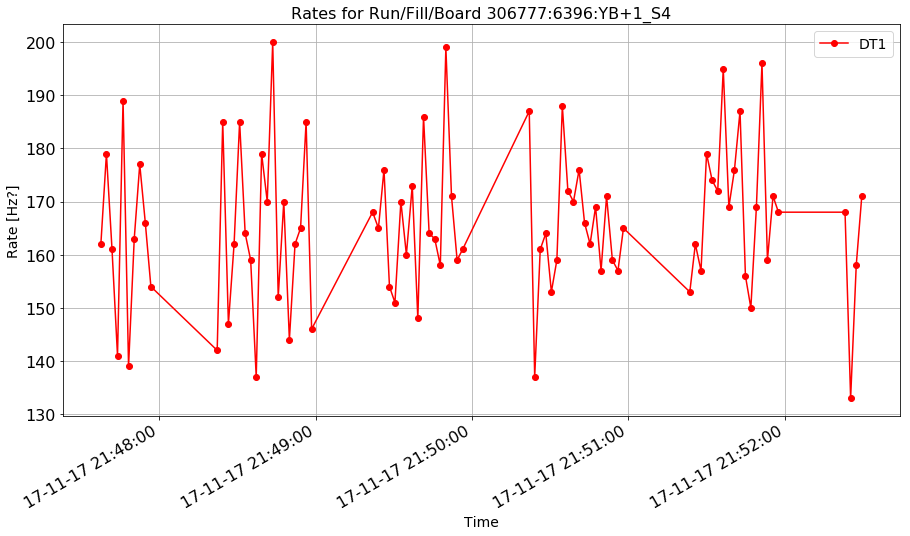

In [69]:
def plot_rate(df, x_val, y_val, z_val, title):
    df_temp = df.copy()
    crit = df_temp["board"] == "YB+1_S4"
    df_temp = df_temp[crit]
    print df_temp
    import datetime
    import matplotlib.dates as mdates
    fig, ax = plt.subplots()
    plt.xlabel("Time")
    plt.ylabel("Rate [Hz?]")
    ax.xaxis_date()
    xfmt = mdates.DateFormatter('%d-%m-%y %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    ax.grid()
    fig.autofmt_xdate()
    plt.plot(df_temp[x_val], df_temp[y_val], 'ro-')
    plt.title(title)
    plt.legend(loc="best")
    plt.show();


plot_rate(df_rates, "time", "DT1", "YB+1_S4", "Rates for Run/Fill/Board "+int_lumi["run:fill"][2]+":YB+1_S4")